# Непараметрические критерии


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from statsmodels.stats.multitest import multipletests
from statsmodels.sandbox.stats.multicomp import multipletests
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

### Критерий Смирнова <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \not= G$

Альтернатива двусторонняя, б*о*льшие значения статистики являются более экстремальными.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp">`ks_2samp`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки

---

Определим несколько вспомогательных функций для отрисовки графиков

In [5]:
def ecdf(sample):
    """
    Вычисляет точки по X и по Y для построения ЭФР по выборке sample.
    Учитываются как горизонтальные, так и вертикальные линии.
    """

    # дублируем выборку и добавляем значения слева и справа
    x = deepcopy(list(sample)*2 + [sample.min()-0.5, sample.max()+0.5])
    # каждое значение два раза
    y = deepcopy(list(np.linspace(0, 1, len(sample)+1)) * 2)

    return np.sort(x), np.sort(y)


def max_diff(x1, x2, y1, y2):
    """ Вычисляет, где достигается максимальная разница между двумя ЭФР. """

    # объединим наборы и отсортируем по иксу
    x_all, y_all = np.hstack([x1, x2]), np.hstack([y1, y2])
    order = np.argsort(x_all)
    x_all, y_all = x_all[order], y_all[order]

    # найдем индекс наибольшейарзницы по Y между соседними
    i = np.argmax(np.abs(y_all[1:] - y_all[:-1]))

    # точка наибольшей разности и значения  в ней
    return (x_all[i+1] + x_all[i]) / 2, y_all[i], y_all[i+1]

In [7]:
def apply_smirnov(distr1, distr2, size1=100, size2=100):
    """
    Генерирует выборки из заданных распределений,
    строит графики теоретических и эмпирических функций распределения,
    применяет критерий Смирнова.

    distr1, distr2 &mdash; распределения для генерации выборок
    size1, size2 &mdash; размеры выборок
    """

    # генерируем выборки
    sample_1 = distr1.rvs(size=size1)
    sample_2 = distr2.rvs(size=size2)

    # определяем границы графика
    x_min = min(distr1.ppf(0.01), distr2.ppf(0.01))
    x_max = max(distr1.ppf(0.99), distr2.ppf(0.99))
    grid = np.linspace(x_min, x_max, 200)

    plt.figure(figsize=(16, 5))

    # График истинных функций распределения
    plt.subplot(121)
    plt.plot(grid, distr1.cdf(grid), lw=3)
    plt.plot(grid, distr2.cdf(grid), lw=3)
    plt.title('CDF')

    # График эмпирических функций распределения
    plt.subplot(122)
    x1, y1 = ecdf(sample_1)
    plt.plot(x1, y1, lw=3)
    x2, y2 = ecdf(sample_2)
    plt.plot(x2, y2, lw=3)
    plt.vlines(*max_diff(x1, x2, y1, y2), color='gray')
    plt.title('ECDF')

    # Применяем критерий Смирнова
    print(sps.ks_2samp(sample_1, sample_2))

Сравним нормальные с разными средними

In [10]:
apply_smirnov(sps.norm(loc=0), sps.norm(loc=1))

KstestResult(statistic=0.33, pvalue=3.211428734211389e-05, statistic_location=0.513469207350918, statistic_sign=1)


Сравним нормальные с разными дисперсиями и разными размерами выборок

KstestResult(statistic=0.23, pvalue=0.08493406983517855, statistic_location=1.4320862153329799, statistic_sign=1)


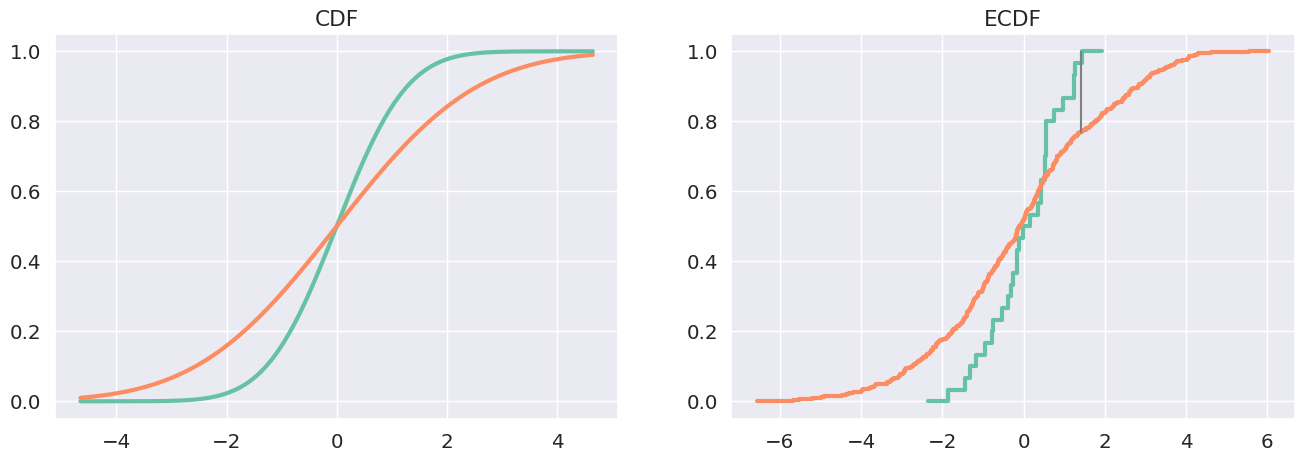

In [5]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=30, size2=500)

Если увеличить размер выборки

KstestResult(statistic=0.2, pvalue=3.6740572722559346e-09, statistic_location=1.1209642674358091, statistic_sign=1)


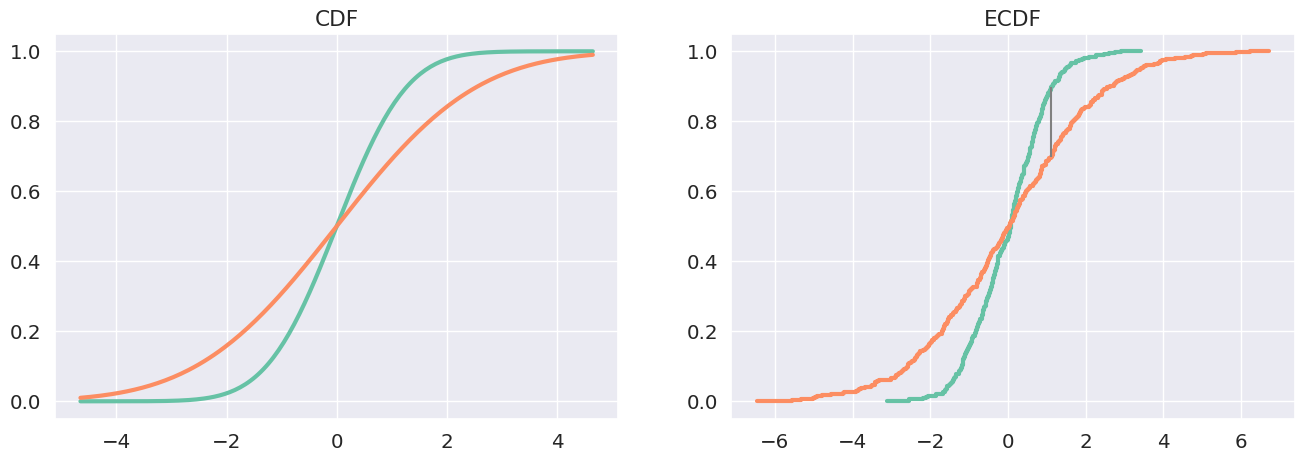

In [6]:
apply_smirnov(sps.norm(loc=0, scale=1), sps.norm(loc=0, scale=2),
              size1=500, size2=500)

Маленькое отклонение при очень больших выборках

KstestResult(statistic=0.015059999999999962, pvalue=2.352270779080369e-05, statistic_location=0.24839654942195952, statistic_sign=1)


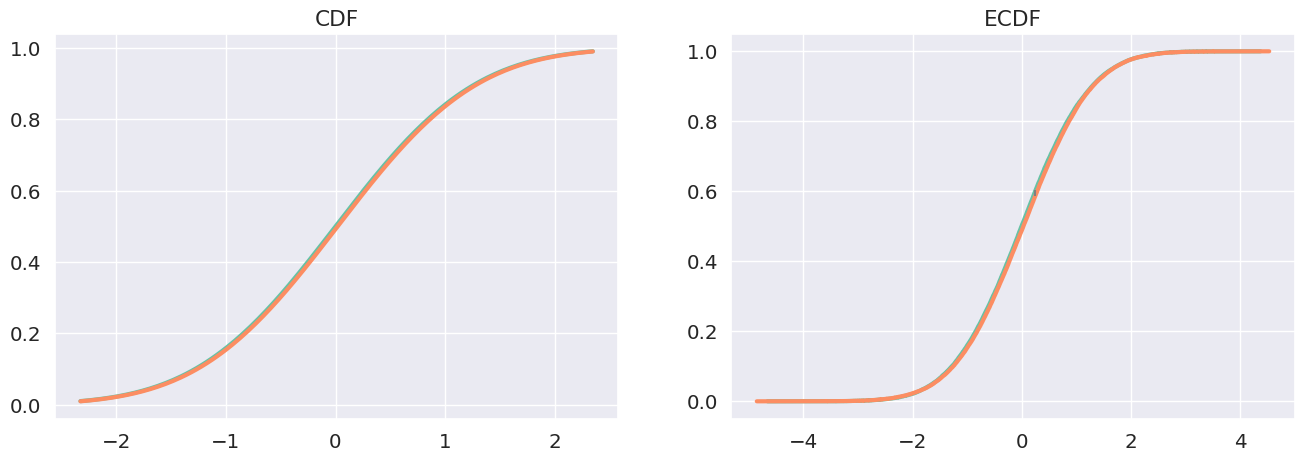

In [7]:
apply_smirnov(sps.norm, sps.norm(loc=0.02),
              size1=50000, size2=50000)

Сравним нормальное и Коши

KstestResult(statistic=0.17, pvalue=0.11119526053829192, statistic_location=1.8929268338798653, statistic_sign=1)


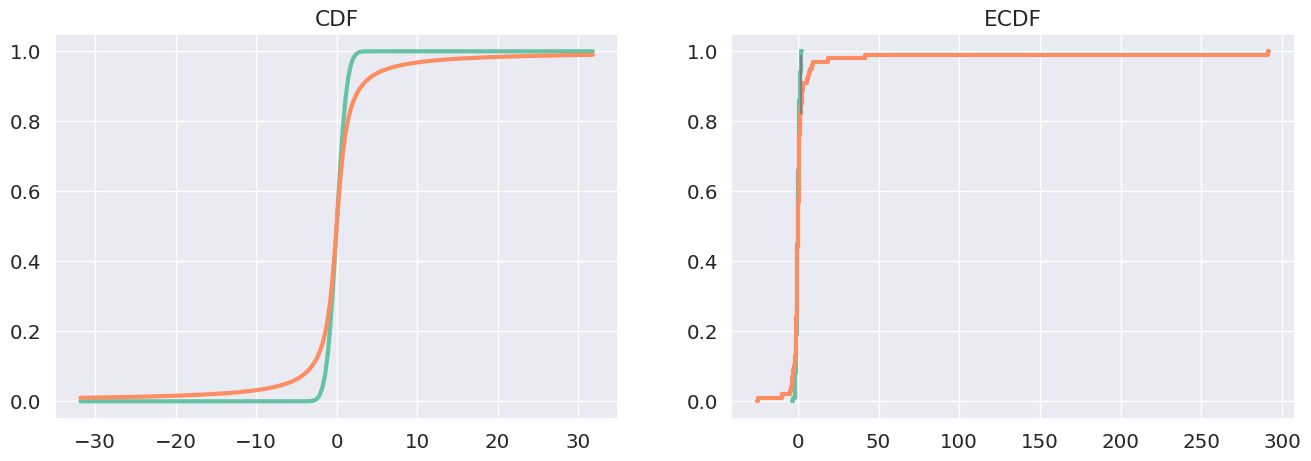

In [8]:
apply_smirnov(sps.norm, sps.cauchy)

Сравним нормальное и Лапласса

KstestResult(statistic=0.09, pvalue=0.8154147124661313, statistic_location=-0.26086859946289814, statistic_sign=1)


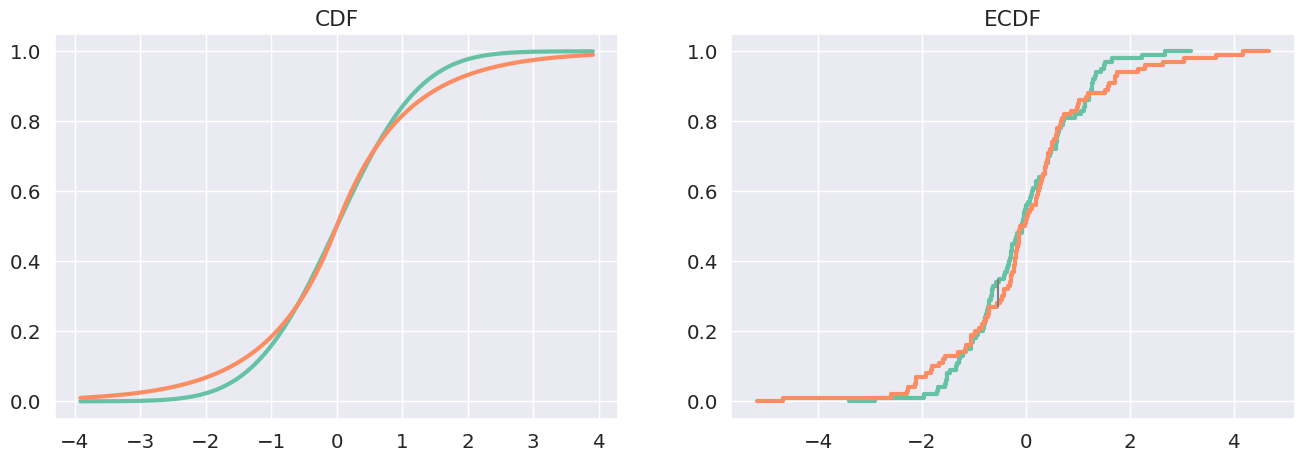

In [9]:
apply_smirnov(sps.norm, sps.laplace)

### Критерий ранговых сумм Уилкоксона-Манна-Уитни <font color="red">(независимые выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_m$ &mdash; независимые выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

------

* **"Критерий Уилкоксона"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем это не значит, что $\mathsf{H}_1\colon F \not= G$.

Используется нормированная версия статистики $V = S_1 + ... + S_m$ &mdash; сумма рангов наблюдений $Y_j$ по объединенной выборке.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html#scipy.stats.ranksums">`ranksums`</a>`(data1, data2): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки.

------

* **"Критерий Манна-Уитни"**

$\mathsf{H}_0\colon F = G$

$\mathsf{H}_1\colon F \leqslant G$ или $\mathsf{H}_1\colon F \geqslant G$ или $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$

Используется статистика $U = \sum\limits_{i=1}^n \sum\limits_{j=1}^m I\{X_i < Y_j\}$, причем $U = V - \frac{m(m+1)}{2}$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu">`mannwhitneyu`</a>`(data1, data2, use_continuity=True, alternative=None): statistic, pvalue`

* `data1`, `data2` &mdash; две выборки;

* `use_continuity` &mdash; использовать ли поправку 0.5 на непрерывность;
* `alternative='less'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \leqslant G$;
* `alternative='greater'` &mdash; используется альтернатива $\mathsf{H}_1\colon F \geqslant G$;
* `alternative='two-sided'` &mdash; используется альтернатива $\mathsf{H}_1\colon \{F \leqslant G \text{ или } F \geqslant G\}$, причем эквивалентен `ranksums`.

---

Примеры

In [10]:
def print_tests(sample_1, sample_2):
    print(sps.ranksums(sample_1, sample_2))
    print('two-sided:', sps.mannwhitneyu(sample_1, sample_2, alternative='two-sided'))
    print('less:     ', sps.mannwhitneyu(sample_1, sample_2, alternative='less'))
    print('greater:  ', sps.mannwhitneyu(sample_1, sample_2, alternative='greater'))

In [11]:
print_tests(sps.norm.rvs(size=100), sps.norm.rvs(size=100))

RanksumsResult(statistic=0.35917816640753736, pvalue=0.7194618090114608)
two-sided: MannwhitneyuResult(statistic=5147.0, pvalue=0.7203758883709399)
less:      MannwhitneyuResult(statistic=5147.0, pvalue=0.6407259346662892)
greater:   MannwhitneyuResult(statistic=5147.0, pvalue=0.36018794418546995)


In [12]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1).rvs(size=100))

RanksumsResult(statistic=-6.343037550979367, pvalue=2.2527849148791567e-10)
two-sided: MannwhitneyuResult(statistic=2404.0, pvalue=2.2707263447029282e-10)
less:      MannwhitneyuResult(statistic=2404.0, pvalue=1.1353631723514641e-10)
greater:   MannwhitneyuResult(statistic=2404.0, pvalue=0.999999999888251)


In [13]:
print_tests(sps.norm.rvs(size=100), sps.norm(loc=1, scale=10).rvs(size=100))

RanksumsResult(statistic=-2.5899922203536705, pvalue=0.00959781009391863)
two-sided: MannwhitneyuResult(statistic=3940.0, pvalue=0.009631925706165195)
less:      MannwhitneyuResult(statistic=3940.0, pvalue=0.004815962853082598)
greater:   MannwhitneyuResult(statistic=3940.0, pvalue=0.9952180988705186)


In [14]:
print_tests(sps.cauchy.rvs(size=100), sps.cauchy(loc=1).rvs(size=100))

RanksumsResult(statistic=-5.568483273760392, pvalue=2.569662904512788e-08)
two-sided: MannwhitneyuResult(statistic=2721.0, pvalue=2.5877378790849446e-08)
less:      MannwhitneyuResult(statistic=2721.0, pvalue=1.2938689395424723e-08)
greater:   MannwhitneyuResult(statistic=2721.0, pvalue=0.9999999872414476)


### Критерий ранговых сумм Уилкоксона <font color="red">(парные выборки)</font>

$X_1, ..., X_n$ и $Y_1, ..., Y_n$ &mdash; связные выборки, имеющие непрерывные функции распределения $F$ и $G$ соответственно.

Предполагается, что $Z_i = Y_i - X_i = \theta + \varepsilon_i$, причем $\varepsilon_i$ независимы одинаково распределены, причем распределение непрерывное симметричное относительно нуля.

Проверяются гипотезы

$\mathsf{H}_0\colon \theta = 0$,

$\mathsf{H}_1\colon \theta \not= 0$.

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon">`wilcoxon`</a>`(x, y=None, zero_method='wilcox'): statistic, pvalue`

* `x`, `y` &mdash; выборки. Если `y=None`, то в `x` разности;
* `zero_method='pratt'` &mdash; нулевые разности остаются (более консервативен);
* `zero_method='wilcox'` &mdash; нулевые разности выкивываются;
* `zero_method='zsplit'` &mdash; нулевые разности распределяются между положительными и отрицательными рангами.

---

Примеры:

In [15]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=2080.0, pvalue=0.12600322563335334)

In [16]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=496.0, pvalue=3.029235216778424e-12)

In [17]:
sample_1 = sps.norm(loc=0).rvs(size=100)
sample_2 = sample_1 + sps.norm(loc=-0.5, scale=0.5).rvs(size=100)
sps.wilcoxon(sample_1, sample_2)

WilcoxonResult(statistic=335.0, pvalue=5.076698437799151e-14)

Времена реакции (Лагутин)

In [18]:
sample_1 = [176, 163, 152, 155, 156, 178, 160, 164, 169, 155, 122, 144]
sample_2 = [168, 215, 172, 200, 191, 197, 183, 174, 176, 155, 115, 163]
print('wilcox:', sps.wilcoxon(sample_1, sample_2))
print('pratt: ', sps.wilcoxon(sample_1, sample_2, zero_method='pratt'))
print('zsplit:', sps.wilcoxon(sample_1, sample_2, zero_method='zsplit'))

wilcox: WilcoxonResult(statistic=4.5, pvalue=0.011197738894413023)
pratt:  WilcoxonResult(statistic=6.5, pvalue=0.011931715346446874)
zsplit: WilcoxonResult(statistic=7.0, pvalue=0.011997435448298963)


## Отток клиентов телекома

Загрузим <a href="https://github.com/Yorko/mlcourse_open/blob/master/data/telecom_churn.csv">данные</a> о клиентах оператора связи, которые содержат некоторую информацию тарифном плане клиента, статистику его использования услуг связи, а также его текущий статус `Churn` &mdash; ушел или нет.

In [19]:
telecom = pd.read_csv('./telecom_churn.csv')
telecom.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### Одинаково ли распределено количество минут днем?

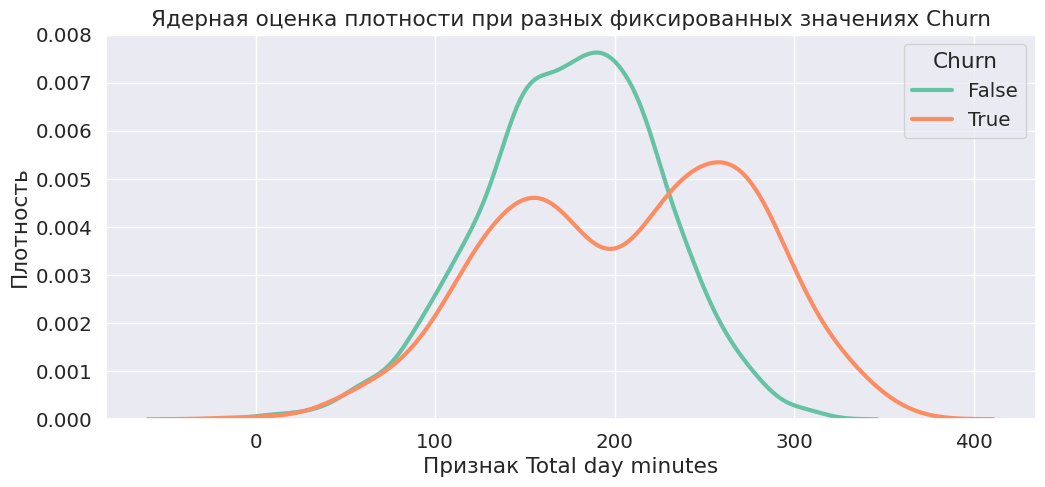

In [20]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total day minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total day minutes'],
            label='True', lw=3)
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности при разных фиксированных значениях Churn')
plt.ylabel('Плотность')
plt.xlabel('Признак Total day minutes')

plt.show()

Проверьте гипотезу однородности.

Какой критерий вы бы выбрали? Какую альтернативу стоит использовать?

In [21]:
x = telecom[telecom['Churn'] == False]['Total day minutes']
y = telecom[telecom['Churn'] == True]['Total day minutes']

sps.mannwhitneyu(x, y, alternative='two-sided')

MannwhitneyuResult(statistic=495604.0, pvalue=6.715053420859948e-23)

Для дальнейшего использования реализуем функцию оценки сдвига и функцию доверительного интервала оценки.

Учтите, что по сравнению с формулами для доверительного интервала, из индексов надо вычесть 1, поскольку используется нумерация с нуля.


Оценка сдвига (без вывода):
$$\widehat{\theta} = med\{W_{ij} = Y_j - X_i, i=1..n, j=1..m\}$$

Доверительный интервал (без вывода):
$$(W_{(k_\alpha + 1)}, W_{(nm - k_\alpha)})$$
$$k_\alpha = \left\lfloor nm/2 - 1/2 - z_{1-\alpha} \sqrt{nm(n+m+1)/12} \right\rfloor$$

In [22]:
def shift(x, y):
    '''Вычисление оценки параметра сдвига'''
    W = (y.to_numpy()[:, np.newaxis] - x.to_numpy()[np.newaxis, :]).ravel()
    shift = np.median(W)
    return shift

def confidence_interval(x, y, alpha=0.05):
    '''Вычисление границ доверительного интервала параметра сдвига из критерия ранговых сумм Уилкоксона'''
    n, m = len(x), len(y)
    z = sps.norm.ppf(1 - alpha)
    k_a = int(np.floor(n*m/2 - 0.5 - z * np.sqrt(n*m*(n+m+1)/12)))
    W = (y.to_numpy()[:, np.newaxis] - x.to_numpy()[np.newaxis, :]).ravel()
    W.sort()
    left, right = W[k_a], W[n*m-k_a-1]
    return left, right

Оценим сдвиг

In [23]:
shift(x, y)

33.80000000000001

Получите доверительный интервал величины сдвига.

In [24]:
confidence_interval(x, y)

(28.30000000000001, 39.30000000000001)

### Одинаково ли распределено количество минут ночью?

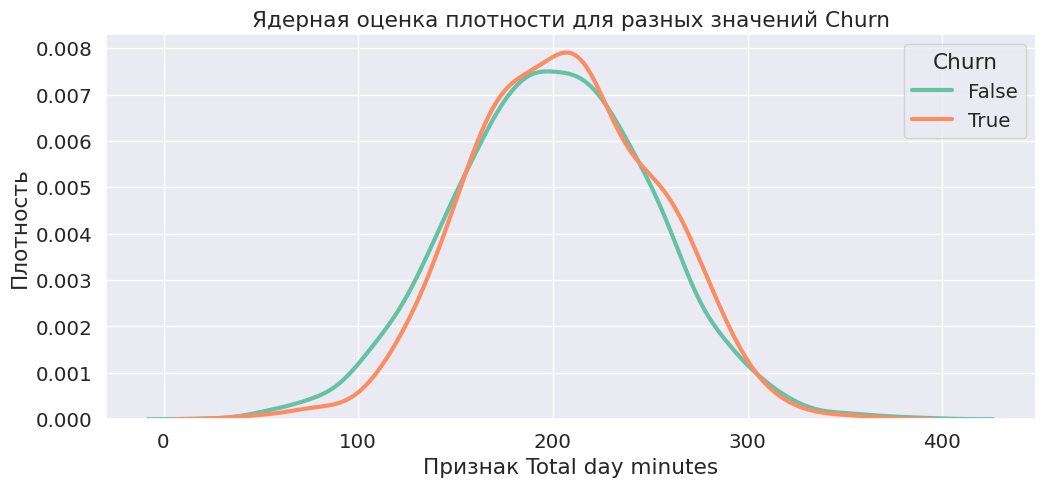

In [25]:
plt.figure(figsize=(12, 5))
sns.kdeplot(telecom[telecom['Churn'] == False]['Total night minutes'],
            label='False', lw=3)
sns.kdeplot(telecom[telecom['Churn'] == True]['Total night minutes'],
            label='True', lw=3)
plt.xlabel('Признак Total day minutes')
plt.legend(title='Churn')

plt.title('Ядерная оценка плотности для разных значений Churn')
plt.ylabel('Плотность')

plt.show()

Проверьте с помощью критерия.

In [26]:
x = telecom[telecom['Churn'] == False]['Total night minutes']
y = telecom[telecom['Churn'] == True]['Total night minutes']

sps.mannwhitneyu(x, y, alternative='two-sided')

MannwhitneyuResult(statistic=649507.0, pvalue=0.04744034531465515)

Получим оценку сдвига.

In [27]:
shift(x, y)

4.900000000000006

Получим доверительный интервал.

In [28]:
confidence_interval(x, y)

(0.8000000000000114, 9.0)

Несмотря на то, что гипотеза отвергается, результат очень ненадёжный, исходя из полученного p-value. Как видим, разница составляет всего 5 минут, в то время как значения выборки 100-300 минут. Т.е. имеется статистическая значимость, в то время как практической значимости полученный результат не имеет. А доверительный интервал сдвига близок к нулю.